## Runs DE on different clusters. Also runs DE within each cluster for each condition.
Does this over each donor and combined

In [1]:
# Input info
se_f = "/data/Mito_Trace/output/pipeline/v02/TcellDupi_may17_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/gff_hg38_1_2/annotation_clones/SE.rds"
clone_changes_f = "/data/Mito_Trace/output/pipeline/v02/TcellDupi_may17_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/gff_hg38_1_2/annotation_clones/clones_change/filt_fisher__shuffle_True__padj_True__pthresh_0.01_minC_1__bothMinC__0/preproc/clone_change.csv"

outdir = "/data/Mito_Trace/output/pipeline/v02/TcellDupi_may17_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/gff_hg38_1_2/annotation_clones/clones_change/filt_fisher__shuffle_True__padj_True__pthresh_0.01_minC_1__bothMinC__0/de/inChange_btwnConds/minPct_0.01__logfc0.1_pthresh_0.01"
sample_names = "pre,post"

# Parallel processing
cores = 4
# R utils script
utils_script <- "/data/Mito_Trace/R_scripts/seurat_utils.R"

top_de = 3
logfcthresh=0.1
minPct = 0.01
p_thresh=0.01

In [2]:
outdir


[1] "/data/Mito_Trace/output/pipeline/v02/TcellDupi_may17_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/gff_hg38_1_2/annotation_clones/clones_change/filt_fisher__shuffle_True__padj_True__pthresh_0.01_minC_1__bothMinC__0/de/inChange_btwnConds/minPct_0.01__logfc0.1_pthresh_0.01"

In [3]:
source(utils_script)
source("/data/Mito_Trace/R_scripts/plot_de_over_all.R")
dir.create(outdir)
donor.outdir <- file.path(outdir, "sepDonors")
dir.create(donor.outdir)

all.donor.outdir <- file.path(outdir, "allDonors")
dir.create(all.donor.outdir)

Attaching SeuratObject


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Warning message in dir.create(outdir):
“'/data/Mito_Trace/output/pipeline/v02/TcellDupi_may17_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/gff_hg38_1_2/annotation_clones/clones_change/filt_fisher__shuffle_True__padj_True__pthresh_0.01_minC_1__bothMinC__0/de/inChange_btwnConds/minPct_0.01__logfc0.1_pthresh_0.01' already exists”
Warning message in dir.create(donor.outdir):
“'/data/Mito_Trace/output/pipeline/v02/TcellDupi_may17_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/gff_hg38_1_2/annotation_clones/clones_change/filt_fisher__shuffle

In [4]:
sample_names <- unlist(strsplit(sample_names, ",")[[1]])
sample_names

[1] "pre"  "post"

In [5]:
library(GenomicRanges)
library(Seurat)
library(Signac)
library(GenomeInfoDb)
library(EnsDb.Hsapiens.v75)
library(ggplot2)
library(patchwork)
set.seed(1234)
library(data.table)
library(magrittr)
library(cowplot)
library(metap)
library("RColorBrewer")
library(dplyr)
library(future)
plan()

plan("multiprocess", workers = cores)
#options(future.globals.maxSize = 50000 * 1024^2) # for 50 Gb RAM
options(future.globals.maxSize = 8000 * 1024^2)

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


Loading required package: S4Vectors


Attaching package: ‘S4Vectors’


The following objects are masked from ‘package:dplyr’:

    first, rename


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Loading required package:

sequential:
- args: function (..., envir = parent.frame())
- tweaked: FALSE
- call: NULL

Warning message:
"Strategy 'multiprocess' is deprecated in future (>= 1.20.0). Instead, explicitly specify either 'multisession' or 'multicore'. In the current R session, 'multiprocess' equals 'multicore'."


In [6]:
se <- readRDS(se_f)#file.path(indir, paste0("allSamples.integrated.rds")))
se

An object of class Seurat 
97805 features across 22239 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap

# Load clone_changes

In [7]:
clone_changes <- read.csv(clone_changes_f)
row.names(clone_changes) <-clone_changes$name

In [8]:
clone_changes[c("name","change")]

,name,change
,<chr>,<chr>
0_5,0_5,regress
0_25,0_25,regress
0_8,0_8,expand
0_12,0_12,regress
0_17,0_17,expand
1_39,1_39,regress
1_1,1_1,regress
0_11,0_11,regress
0_24,0_24,regress


## Subset clones

### Add change col metadata for each clone
a) subset se by clone names
b) need to map each cell based on the clone value, create a dataframe. should be same number rows as se

In [9]:
se.filt <- subset(se , subset = name %in% clone_changes$name)
se.filt = subset(se.filt , subset = (name != "None"))

In [10]:
meta <- se.filt[[]]
meta$change <- NA
for (cell in row.names(meta)){
    curr <- clone_changes[as.character(meta[cell, "name"]),"change"]
    print(curr)
    if(is.na(curr)){
        break
    }
    meta[cell, "change"] = curr
}

se.filt <- AddMetaData(se.filt, meta[["change"]], col.name="change")


[1] "regress"
[1] "regress"
[1] "regress"
[1] "no_change"
[1] "regress"
[1] "no_change"
[1] "regress"
[1] "no_change"
[1] "expand"
[1] "no_change"
[1] "regress"
[1] "expand"
[1] "no_change"
[1] "regress"
[1] "expand"
[1] "regress"
[1] "regress"
[1] "expand"
[1] "regress"
[1] "regress"
[1] "no_change"
[1] "regress"
[1] "no_change"
[1] "no_change"
[1] "no_change"
[1] "expand"
[1] "regress"
[1] "expand"
[1] "no_change"
[1] "expand"
[1] "no_change"
[1] "regress"
[1] "regress"
[1] "regress"
[1] "no_change"
[1] "regress"
[1] "expand"
[1] "no_change"
[1] "expand"
[1] "no_change"
[1] "no_change"
[1] "expand"
[1] "no_change"
[1] "no_change"
[1] "regress"
[1] "no_change"
[1] "no_change"
[1] "regress"
[1] "no_change"
[1] "no_change"
[1] "no_change"
[1] "regress"
[1] "no_change"
[1] "no_change"
[1] "no_change"
[1] "expand"
[1] "regress"
[1] "expand"
[1] "no_change"
[1] "no_change"
[1] "regress"
[1] "no_change"
[1] "regress"
[1] "regress"
[1] "no_change"
[1] "expand"
[1] "expand"
[1] "no_change"
[1

In [11]:
se.filt$change.stim <- paste(se.filt$change, se.filt$orig.ident, sep = "_")
#clone.ids <- sort(unique(se$name))
#se$clone <- se$name

Idents(se.filt) <- "change.stim"



In [12]:
# run.de <- function(p){
#     ident.1 = p[[1]] # paste0(curr.clone, "_", sample_names[[1]]) 
#     ident.2 = p[[2]] #paste0(curr.clone, "_", sample_names[[2]])

#     curr.name <- paste("donor", curr.d, ident.1, "vs", ident.2, sep="_")
#     curr.dir <- paste0("donor", "_", curr.d)
#     curr.outdir <- file.path(donor.outdir, curr.dir)
#     dir.create(curr.outdir)

#     ## Run DE
#     curr.sig <- find.markers.and.plot(curr.se, ident.1, ident.2, curr.outdir, 
#                                       curr.name=curr.name, assay="RNA", logfcthresh=logfcthresh,
#                                       min.pct=minPct, p.thresh=p_thresh, mean.fxn=NULL, fc.name=NULL)
#     return(curr.sig)
    
# }

# Run DE

## a) Donors combined

In [13]:
all.pvals <- data.frame(matrix(nrow=dim(se.filt)[1],ncol=0),
                          row.names=row.names(se.filt))
all.names.sig <- c()

curr.se <- se.filt
changes <- unique(curr.se$change)
print(changes)

[1] "regress"   "no_change" "expand"   


In [14]:
if (length(changes)<2){
    print("Only one type of change for clone in this donor")
}else{
    #curr.sigs <- lapply(pairs, 2, run.de)  
    for (c in changes){
        print("change")
        print(c)
        
        ident.1 = paste0(c, "_", sample_names[[1]]) 
        ident.2 = paste0(c, "_", sample_names[[2]]) 

        curr.name <- paste(ident.1, "vs", ident.2, sep="_")
        curr.outdir <- all.donor.outdir #file.path(donor.outdir, curr.dir)

        ## Run DE
        curr.sig <- find.markers.and.plot(se.filt, ident.1, ident.2, curr.outdir, 
                                          curr.name=curr.name, assay="RNA", logfcthresh=logfcthresh,
                                          min.pct=minPct, p.thresh=p_thresh, mean.fxn=NULL, fc.name=NULL)
        #curr.sig <- run.de(p)
        
        # Add DE to global results
        names.sig <- rownames(curr.sig)
        all.names.sig <- c(all.names.sig, head(names.sig, top_de))
        all.pvals[names.sig,curr.name] <- curr.sig$p_val_adj_BH
    
    }
   
}


[1] "change"
[1] "regress"
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 2628 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
                      p_val avg_log2FC pct.1 pct.2    p_val_adj p_val_adj_BH
RAPGEF1        1.116596e-27  0.1897272 0.582 0.303 2.185736e-23 3.249294e-25
DEAF1          2.685450e-22  0.1424308 0.578 0.314 5.256768e-18 3.332107e-20
EPS8L2         3.435161e-22  0.1382265 0.592 0.323 6.724329e-18 3.332107e-20
CDC37          4.803625e-22  0.1293575 0.379 0.175 9.403096e-18 3.494637e-20
TNFRSF1B       1.578982e-21  0.1288675 0.505 0.264 3.090857e-17 9.189675e-20
HNRNPUL2-BSCL2 2.182292e-21  0.1670805 0.675 0.393 4.271836e-17 1.058411e-19
[1] "dim response"
[1] 291   6


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH"


Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

Saving 6.67 x 6.67 in image



[1] "change"
[1] "no_change"
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 9136 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
                p_val avg_log2FC pct.1 pct.2    p_val_adj p_val_adj_BH
MAP2K2   4.091122e-73  0.1191411 0.373 0.175 8.008371e-69 1.558717e-70
BCL3     8.217863e-69  0.1175183 0.366 0.173 1.608647e-64 1.565503e-66
TNFRSF1B 3.392975e-66  0.1518673 0.506 0.280 6.641749e-62 4.309078e-64
FNBP1    3.730046e-64  0.1966462 0.750 0.494 7.301565e-60 3.552869e-62
ZC3H7A   5.388786e-64  0.1306635 0.455 0.241 1.054855e-59 4.106255e-62
ZNF573   1.489842e-63  0.1040589 0.286 0.128 2.916366e-59 9.460497e-62
[1] "dim response"
[1] 381   6


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH"


Saving 6.67 x 6.67 in image



[1] "change"
[1] "expand"
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 2967 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
                  p_val avg_log2FC pct.1 pct.2    p_val_adj p_val_adj_BH
PRR36      2.072282e-20  0.1016780 0.339 0.149 4.056492e-16 6.942145e-18
KIFC1      1.542346e-17  0.1153677 0.400 0.200 3.019142e-13 2.003257e-15
SLC16A6    1.793962e-17  0.1103507 0.424 0.215 3.511680e-13 2.003257e-15
AC005943.2 2.752785e-17  0.1025108 0.287 0.128 5.388576e-13 2.305457e-15
IL4I1      7.947825e-17  0.1055860 0.329 0.158 1.555787e-12 5.325043e-15
DAZAP1     9.653995e-17  0.1014824 0.309 0.145 1.889770e-12 5.390147e-15
[1] "dim response"
[1] 335   6


The automatically generated colors map from the 1^st and 99^th of the
values in the matrix. There are outliers in the matrix whose patterns
might be hidden by this color mapping. You can manually set the color
to `col` argument.

Use `suppressMessages()` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH"


Saving 6.67 x 6.67 in image



Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



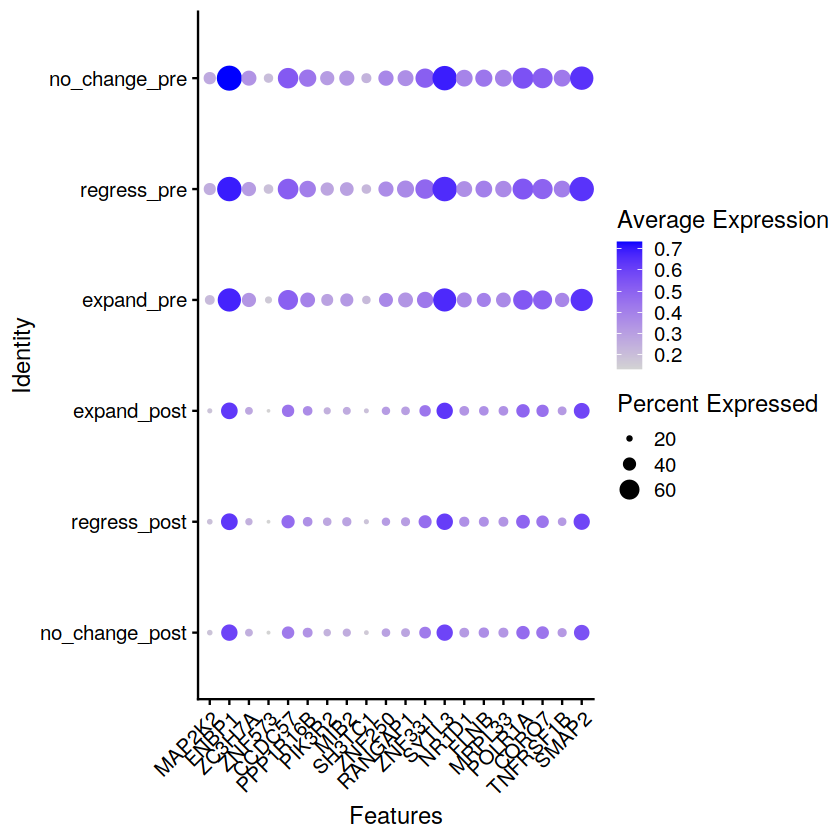

In [15]:

### a) top 3 significant results from each comparison
if (length(all.names.sig)>0){
    all.names.sig <- unique(all.names.sig)
    de.plots(se.filt, all.names.sig, all.donor.outdir, curr.name="allDonors.allClusters", max.size=15)

    dot <- DotPlot(se.filt, scale=FALSE,
                   features = head(all.names.sig,20), 
                   cluster.idents=T) + RotatedAxis()
    dot
    ggsave(file.path(all.donor.outdir, "allDonors.allClusters.top3de.png"))
    ggsave(file.path(all.donor.outdir, "allDonors.allClusters.top3de.pdf"))
    }


## b) averaged top p-values (only average ones that were DE)
try({
sig.all.ordered <- sort(rowMeans(-log10(all.pvals),na.rm=T), decreasing=T)
dot <- DotPlot(se.filt, scale=T,
               features = names(head(sig.all.ordered,20)), 
               cluster.idents=T) + RotatedAxis()
dot
ggsave(file.path(all.donor.outdir, "allDonors.allClusters.pvalsOrdered.png"))
ggsave(file.path(all.donor.outdir, "allDonors.allClusters.pvalsOrdered.pdf"))
#de.plots(se, names(sig.all.ordered), outdir, curr.name="allDonors.allClusters.pvalsOrdered", max.size=20)

sig.all.ordered <- sort(rowMeans(-log10(all.pvals),na.rm=T), decreasing=T)
dot <- DotPlot(se.filt, scale=F,
               features = head(names(sig.all.ordered),20), 
               cluster.idents=T) + RotatedAxis()
dot
    
})

## b) For each donor, de for expanded vs regressed vs no change

[1] "donor 0"
[1] "de"
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 1467 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
               p_val avg_log2FC pct.1 pct.2    p_val_adj p_val_adj_BH
MOB3A   7.102801e-19  0.2085740 0.465 0.189 1.390373e-14 3.657943e-16
RAD9A   8.472389e-17  0.1842179 0.489 0.214 1.658470e-12 2.181640e-14
EIF4G3  6.212659e-16  0.1273542 0.339 0.123 1.216128e-11 7.798176e-14
IZUMO4  6.483036e-16  0.1455283 0.317 0.107 1.269054e-11 7.798176e-14
SEC14L2 7.571044e-16  0.1743530 0.386 0.154 1.482032e-11 7.798176e-14
POLD4   4.278582e-15  0.1287811 0.279 0.088 8.375323e-11 3.344277e-13
[1] "dim response"
[1] 515   6


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH"


Saving 6.67 x 6.67 in image



[1] "de"
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 3550 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
              p_val avg_log2FC pct.1 pct.2    p_val_adj p_val_adj_BH
AP3D1  1.248068e-30  0.1324967 0.401 0.190 2.443093e-26 2.595981e-28
CBX7   1.333985e-26  0.1083262 0.365 0.177 2.611276e-22 9.935651e-25
GSK3A  1.433027e-26  0.1418571 0.529 0.292 2.805150e-22 9.935651e-25
MBD3L1 3.503286e-25  0.1308861 0.369 0.185 6.857683e-21 1.821709e-23
CARM1  7.380513e-25  0.1140358 0.438 0.231 1.444735e-20 3.070293e-23
ZNF558 1.115933e-24  0.1276434 0.372 0.189 2.184439e-20 3.868568e-23
[1] "dim response"
[1] 208   6


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH"


Saving 6.67 x 6.67 in image



[1] "de"
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 1721 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
              p_val avg_log2FC pct.1 pct.2    p_val_adj p_val_adj_BH
AP2A1  1.268766e-13  0.1737827 0.469 0.225 2.483609e-09 3.996472e-11
ILVBL  1.561122e-13  0.1475656 0.304 0.123 3.055896e-09 3.996472e-11
FXR2   1.115590e-12  0.1265240 0.356 0.158 2.183768e-08 1.783354e-10
SWSAP1 1.393245e-12  0.1496973 0.448 0.214 2.727277e-08 1.783354e-10
ACAP3  2.370447e-12  0.1164940 0.255 0.099 4.640149e-08 2.282161e-10
KIFC1  2.674407e-12  0.1430759 0.387 0.181 5.235152e-08 2.282161e-10
[1] "dim response"
[1] 512   6


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH"


Saving 6.67 x 6.67 in image



[1] "donor 1"
[1] "de"
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 1161 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
                p_val avg_log2FC pct.1 pct.2    p_val_adj p_val_adj_BH
ITPKB    1.324755e-30  0.4663101 0.936 0.673 2.593209e-26 1.296936e-27
RAPGEF1  7.878092e-30  0.3770228 0.634 0.254 1.542137e-25 3.856326e-27
RASSF2   4.272097e-23  0.2462948 0.554 0.219 8.362630e-19 1.069349e-20
TNFRSF1B 4.369148e-23  0.2576544 0.616 0.269 8.552607e-19 1.069349e-20
KRT72    1.797414e-20  0.1944667 0.386 0.124 3.518437e-16 3.519336e-18
MAD1L1   3.439539e-20  0.3783858 0.809 0.519 6.732897e-16 5.145689e-18
[1] "dim response"
[1] 979   6


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH"


Saving 6.67 x 6.67 in image



[1] "de"
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 5586 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
                 p_val avg_log2FC pct.1 pct.2     p_val_adj  p_val_adj_BH
ITPKB    4.859152e-110  0.4621387 0.902 0.648 9.511790e-106 4.013659e-107
SNX9      1.561583e-81  0.3416662 0.805 0.497  3.056800e-77  6.449340e-79
TNFRSF1B  9.554076e-81  0.2647549 0.575 0.274  1.870210e-76  2.630556e-78
ZNF573    5.354279e-77  0.1828784 0.365 0.131  1.048100e-72  1.105659e-74
FNBP1     7.722943e-76  0.3068501 0.799 0.486  1.511766e-71  1.086230e-73
KRT72     7.890287e-76  0.1572004 0.334 0.112  1.544524e-71  1.086230e-73
[1] "dim response"
[1] 826   6


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH"


Saving 6.67 x 6.67 in image



[1] "de"
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 1246 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
               p_val avg_log2FC pct.1 pct.2    p_val_adj p_val_adj_BH
KRT72   1.228185e-18  0.1688318 0.346 0.108 2.404173e-14 1.468910e-15
ITPKB   5.365409e-18  0.4909779 0.851 0.636 1.050279e-13 3.208514e-15
CABLES1 3.352456e-17  0.2353540 0.335 0.112 6.562433e-13 1.336513e-14
RASSF2  1.056769e-16  0.2347683 0.517 0.223 2.068625e-12 3.159739e-14
IFITM2  8.685307e-16  0.1715478 0.405 0.156 1.700149e-11 2.077525e-13
ZC3H7A  2.137757e-15  0.2125610 0.543 0.246 4.184659e-11 4.261262e-13
[1] "dim response"
[1] 1196    6


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH"


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



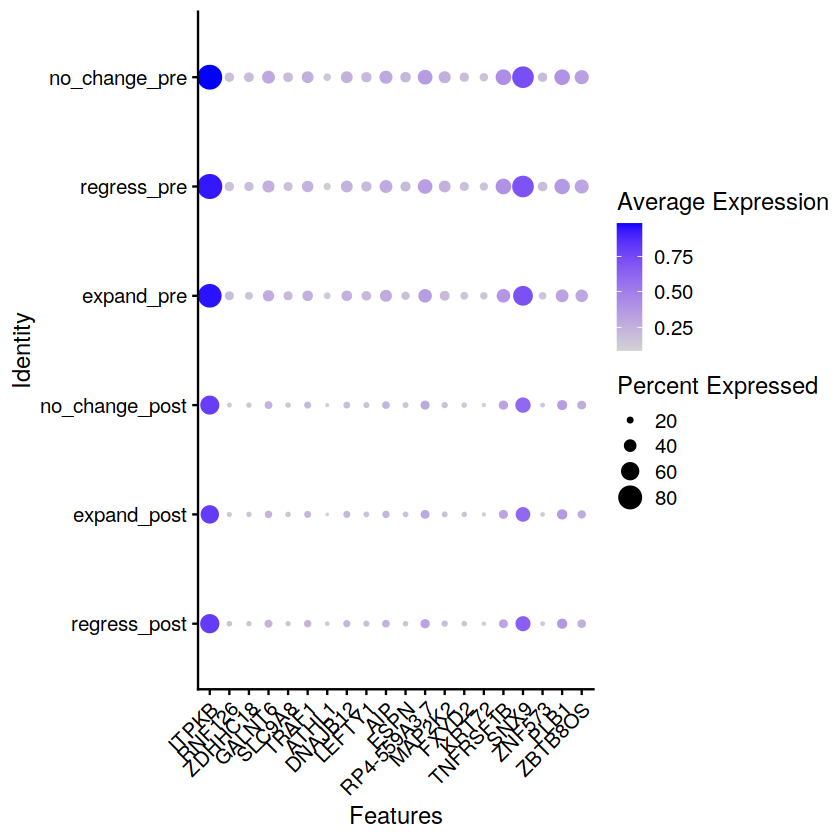

In [17]:
donors <- sort(unique(se.filt$donor))
all.pvals <- data.frame(matrix(nrow=dim(se.filt)[1],ncol=0),
                          row.names=row.names(se.filt))
all.names.sig <- c()
for (curr.d in donors){
    print(paste0("donor ", curr.d))
    curr.se <- subset(se.filt, subset = donor == curr.d)
    changes <- unique(curr.se$change)
    if (length(changes)<2){
        print("Only one type of change for clone in this donor")
        print(changes)
        next
    }
    #curr.sigs <- lapply(pairs, 2, run.de)
    
    for (c in changes){
        print('de')
        ident.1 = paste0(c, "_", sample_names[[1]]) 
        ident.2 = paste0(c, "_", sample_names[[2]]) 

        curr.name <- paste("donor", curr.d, ident.1, "vs", ident.2, sep="_")
        #curr.dir <- paste0("donor", "_", curr.d)
        #curr.outdir <- file.path(donor.outdir, curr.dir)
        curr.outdir <- donor.outdir
        #dir.create(curr.outdir)

        ## Run DE
        curr.sig <- find.markers.and.plot(curr.se, ident.1, ident.2, curr.outdir, 
                                          curr.name=curr.name, assay="RNA", logfcthresh=logfcthresh,
                                          min.pct=minPct, p.thresh=p_thresh, mean.fxn=NULL, fc.name=NULL)
        #curr.sig <- run.de(p)
        
        # Add DE to global results
        names.sig <- rownames(curr.sig)
        all.names.sig <- c(all.names.sig, head(names.sig, top_de))
        all.pvals[names.sig,curr.name] <- curr.sig$p_val_adj_BH
    
    }
   
}

### a) top 3 significant results from each comparison
if (length(all.names.sig)>0){
    all.names.sig <- unique(all.names.sig)
    de.plots(se.filt, all.names.sig, donor.outdir, curr.name="allDonors.allClusters", max.size=15)

    dot <- DotPlot(se.filt, scale=FALSE,
                   features = head(all.names.sig,20), 
                   cluster.idents=T) + RotatedAxis()
    dot
    ggsave(file.path(donor.outdir, "allDonors.allClusters.top3de.png"))
    ggsave(file.path(donor.outdir, "allDonors.allClusters.top3de.pdf"))
    }


## b) averaged top p-values (only average ones that were DE)
try({
sig.all.ordered <- sort(rowMeans(-log10(all.pvals),na.rm=T), decreasing=T)
dot <- DotPlot(se.filt, scale=T,
               features = names(head(sig.all.ordered,20)), 
               cluster.idents=T) + RotatedAxis()
dot
ggsave(file.path(donor.outdir, "allDonors.allClusters.pvalsOrdered.png"))
ggsave(file.path(donor.outdir, "allDonors.allClusters.pvalsOrdered.pdf"))
#de.plots(se, names(sig.all.ordered), outdir, curr.name="allDonors.allClusters.pvalsOrdered", max.size=20)

sig.all.ordered <- sort(rowMeans(-log10(all.pvals),na.rm=T), decreasing=T)
dot <- DotPlot(se.filt, scale=F,
               features = head(names(sig.all.ordered),20), 
               cluster.idents=T) + RotatedAxis()
dot
    
})

In [18]:
sessionInfo()

R version 4.1.1 (2021-08-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 20.04.4 LTS

Matrix products: default
BLAS/LAPACK: /home/isaac/miniconda3/envs/mttrace/lib/libopenblasp-r0.3.18.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] future_1.23.0             RColorBrewer_1.1-2       
 [3] metap_1.1                 cowplot_1.1.1            
 [5] magrittr_2.0.2            data.table_1.14.2        
 [7] patchwork_1.1.1           ggplot2_3.3.5            
 [9] EnsDb.Hsapiens.v75_2.99.0 ensembldb_2.18.1         
[11] 

In [19]:
outdir

[1] "/data/Mito_Trace/output/pipeline/v02/TcellDupi_may17_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/gff_hg38_1_2/annotation_clones/clones_change/filt_fisher__shuffle_True__padj_True__pthresh_0.01_minC_1__bothMinC__0/de/inChange_btwnConds/minPct_0.01__logfc0.1_pthresh_0.01"